In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import itertools
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import re

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
data_path = "/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/raw/"
exp_stage = "final"
task = "shared_control"

pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')
data_files = glob.glob(pattern)

In [4]:
data_path = "/Users/kritiaxh/Documents/PoldrackLab/SharedControl/data/raw/"
exp_stage = "pilot"
task = "shared_control"

pattern = os.path.join(data_path, exp_stage, '*', task, '*.csv')
pilot_files = glob.glob(pattern)

In [5]:
def string_to_numbers(string_data):
    if isinstance(string_data, float):  # Check if the input is already a float
        return [string_data]  # If it's a float, return it as a list
    string_data = string_data.strip("'")  # Remove leading and trailing single quotes
    numbers = [float(num) for num in string_data.split()]
    return numbers

In [6]:
def get_subject_label(file):
    """
    Extract the subject label from a given file path.

    Parameters:
    - file (str): The file path from which to extract the subject label.

    Returns:
    - str or None: The extracted subject label (e.g., 's001') if found, 
                   otherwise returns None and prints a message.
    """
    
    match = re.search(r'/sub-(s\d{3})/', file)
    
    if match:
        subject_label = match.group(1)
        return subject_label
    else:
        print("No subject label found.")
        return None

In [7]:
def process_trial_data(data, exp_stage="final"):
    trial_results = {}
    ssrt_list = []

    for idx, row in data.iterrows():
        trial_number = idx
        stop_onset = row['SSD_mean']    
        time_stamps = row['time_stamps_raw']
        closest_time = min(time_stamps, key=lambda x: abs(x - stop_onset))
        index_of_closest = time_stamps.index(closest_time) # Index of closest time stamp to stop onset
        raw_pressure = row['pressures_raw'][index_of_closest]

        trial_results[trial_number] = {
            'stop_onset': stop_onset,
            'closest_time': closest_time,
            'index_of_closest': index_of_closest,
            'raw_pressure': raw_pressure,
            'distances_raw': row['distances_raw'],
            'pressures_raw': row['pressures_raw'],
            'time_stamps_raw': row['time_stamps_raw'],
            'condition': row['condition']
        }

    for trial_number, trial_data in trial_results.items():
        index_of_closest = trial_data['index_of_closest']
        pressures_raw = trial_data['pressures_raw']
        time_stamps_raw = trial_data['time_stamps_raw']

        found_stop_pressure = None
        stop_moment = None
        for i in range(index_of_closest + 1, len(pressures_raw)):
            if pressures_raw[i] == 0:
                found_stop_pressure = pressures_raw[i]
                stop_moment = time_stamps_raw[i]
                break

        moment_of_inhibition = None
        index_of_inhibition = None
        
        # This is how the moment of inhibition was originally calculated for the pilot subjects in the pre-reg.
        if exp_stage == "pilot":
            if found_stop_pressure is not None:
                for i in range(index_of_closest + 1, len(pressures_raw)):
                    if pressures_raw[i] < pressures_raw[index_of_closest]:
                        moment_of_inhibition = time_stamps_raw[i]
                        index_of_inhibition = i
                        break
        # This is the correct calculation for moment of inhibition
        else:
            if found_stop_pressure is not None:
                for i in range(index_of_closest + 1, len(pressures_raw)):
                    current_pressure = pressures_raw[i]
                    target_pressure = current_pressure * (1 - 0.3)
                    # Check if we have at least 5 more points to examine
                    if i + 5 <= len(pressures_raw):
                        # Check monotonic decrease with special case for pressure of 1
                        is_monotonic = True
                        has_thirty_percent_drop = False
                        for j in range(i+1, i+5):
                            if pressures_raw[j-1] == 1.0:
                                # If previous pressure is 1, next must be strictly less
                                if pressures_raw[j] == 1.0:
                                    is_monotonic = False
                                    break
                            else:
                                # Otherwise, next pressure must be less than or equal
                                if pressures_raw[j] > pressures_raw[j-1]:
                                    is_monotonic = False
                                    break
                            # Check if pressure dropped by at least 30%
                            if pressures_raw[j] <= target_pressure:
                                has_thirty_percent_drop = True
                    if is_monotonic and has_thirty_percent_drop:
                        moment_of_inhibition = time_stamps_raw[i]
                        index_of_inhibition = i
                        pressure_at_moment_of_inhibition = pressures_raw[i]
                        break

        # Find all the 'moments of inhibition' throughout the entire trial even if they are before the stop onset
        moments_of_inhibition = []
        for i in range(len(pressures_raw)):
            current_pressure = pressures_raw[i]
            target_pressure = current_pressure * 0.7
            
            # Check if the pressure decreases to below the target
            if pressures_raw[i] > target_pressure:
                
                # Check if the next pressures monotonically decrease
                decreasing = all(pressures_raw[j] <= pressures_raw[j-1] for j in range(i+1, min(i+5, len(pressures_raw))))
                
                # Also check if any pressure in the next five is below the target pressure
                if decreasing and any(pressures_raw[j] <= target_pressure for j in range(i+1, min(i+5, len(pressures_raw)))):
                    moment_of_inhibition_temp = time_stamps_raw[i]
                    moments_of_inhibition.append(moment_of_inhibition_temp)

        trial_data['stop_pressure'] = found_stop_pressure
        trial_data['stop_moment'] = stop_moment
        trial_data['moment_of_inhibition'] = moment_of_inhibition
        trial_data['index_of_inhibition'] = index_of_inhibition
        trial_data['moments_of_inhibition'] = moments_of_inhibition

        moment_of_inhibition = trial_data['moment_of_inhibition']

        if stop_onset is not None and moment_of_inhibition is not None:
            trial_data['ssrt'] = moment_of_inhibition - trial_data['stop_onset'] 
            ssrt = moment_of_inhibition - trial_data['stop_onset'] 
            ssrt_list.append(ssrt)
        else:
            ssrt_list.append(np.nan)
            trial_data['ssrt'] = np.nan

    return trial_results, ssrt_list

# plotting histogram of moments of inhibition

In [8]:
def get_data(data_files, exp_stage="final"):
    data = {}
    for file in data_files:
        subject = get_subject_label(file)
        df = pd.read_csv(file)
        df['phase_raw'] = df['phase_raw'].str.strip("'")
        df['block_raw'] = df['block_raw'].str.strip("'")

        df_test = df.query("phase_raw == 'test'")
        block_1 = df_test.query("block_raw == 'block 1'")
        block_2 = df_test.query("block_raw == 'block 2'")
        block_1 = block_1.reset_index(drop=True)
        block_2 = block_2.reset_index(drop=True)

        task_dfs = [block_1, block_2]

        for df in task_dfs:
            if 'ai' in df['condition'].values:
                ai_data = df.copy()
                ai_data['distances_raw'] = ai_data['distances_raw'].apply(string_to_numbers)
                ai_data['pressures_raw'] = ai_data['pressures_raw'].apply(string_to_numbers)
                ai_data['time_stamps_raw'] = ai_data['time_stamps_raw'].apply(string_to_numbers)
            else:
                control_data = df.copy()
                control_data['distances_raw'] = control_data['distances_raw'].apply(string_to_numbers)
                control_data['pressures_raw'] = control_data['pressures_raw'].apply(string_to_numbers)
                control_data['time_stamps_raw'] = control_data['time_stamps_raw'].apply(string_to_numbers)

        data[subject] = {'ai': {'data': ai_data}, 'control': {'data': control_data}}

        for block in data[subject].keys():
            trial_results, ssrt_list = process_trial_data(data[subject][block]['data'], exp_stage)
            data[subject][block]['trial_results'] = trial_results
            data[subject][block]['ssrt_list'] = ssrt_list  
    return data

In [9]:
data = get_data(data_files)
master_ssrt = [
    ssrt
    for subject in data.keys()
    for ssrt in data[subject]['control']['ssrt_list']
]

#Print median and mean of master_ssrt after converting ssrt from seconds to milliseconds
print(f'median: {np.nanmedian(master_ssrt)*1000}, mean: {np.nanmean(master_ssrt)*1000}')

median: 263.39882612228394, mean: 269.00869944123787


In [10]:
pilot_data = get_data(pilot_files, "pilot")
master_ssrt_pilot = [
    ssrt
    for subject in pilot_data.keys()
    for ssrt in pilot_data[subject]['control']['ssrt_list']
]

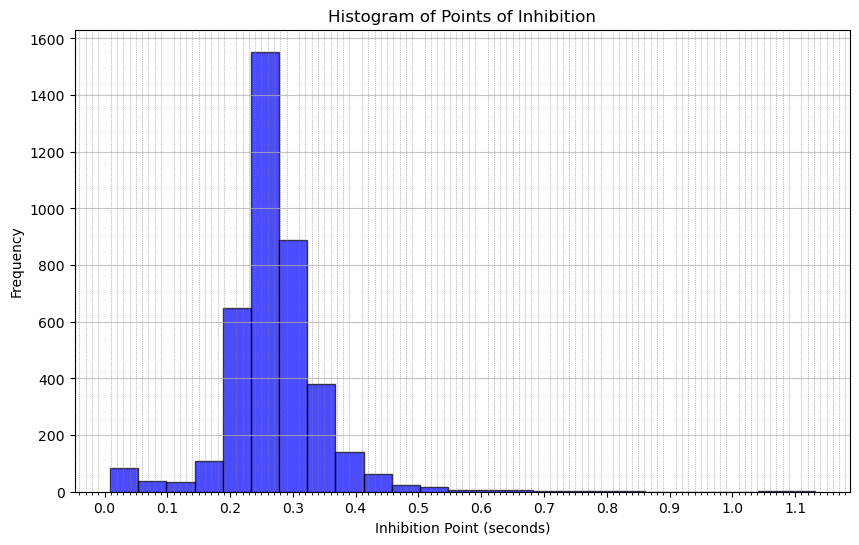

In [11]:
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(master_ssrt, bins=25, color='blue', edgecolor='black', alpha=0.7)

# Labeling the axes and the plot
plt.xlabel('Inhibition Point (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Points of Inhibition')

# Setting x-axis major and minor ticks
plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))  # Major ticks at every 0.1 seconds
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.01))  # Minor ticks at every 0.01 seconds

# Show grid and the plot
plt.grid(axis='y', alpha=0.75)
plt.grid(which='minor', axis='x', linestyle=':', linewidth='0.5', color='gray')  # Minor grid lines

plt.show()

In [12]:
def get_df_all_data(data_files, data):
    all_data = []
    for file in data_files:
        subject = get_subject_label(file)
        df = pd.read_csv(file)
        trial_results = data[subject]['control']['trial_results']
        for trial in trial_results.values():
            ssrt = trial['ssrt']
            stop_onset = trial['stop_onset']
            moments_of_inhibition = trial['moments_of_inhibition']
            all_data.append({'subject': subject, 'ssrt': ssrt, 'stop_onset': stop_onset, 'moments_of_inhibition': moments_of_inhibition})

    # Create DataFrame
    df = pd.DataFrame(all_data)
    return df

In [13]:
def plot_moments_of_inhibition(data_files, data, exp_stage="final"):
    df = get_df_all_data(data_files, data)

    # Median split based on stop_onset
    median_ssd = df['stop_onset'].median()
    low_ssd = df[df['stop_onset'] <= median_ssd]
    high_ssd = df[df['stop_onset'] > median_ssd]

    # Define bin edges for 5 ms intervals
    min_ssrt = df['ssrt'].min() * 1000  # Convert to milliseconds
    max_ssrt = df['ssrt'].max() * 1000  # Convert to milliseconds
    bin_edges = np.arange(min_ssrt, max_ssrt + 5, 5)  # Create bins of size 5 ms

    # Create histogram of SSRT for the full dataset
    plt.figure(figsize=(10, 5))
    plt.hist(df['ssrt'] * 1000, bins=bin_edges, alpha=0.7)  # Convert to milliseconds for the histogram
    plt.axvline(x=175, color='red', linestyle='dashed', linewidth=1, label='175ms')
    plt.xlabel('SSRT (ms)')
    plt.ylabel('Frequency')
    if exp_stage == "final":
        plt.title('Histogram of SSRT Without a Buffer Period')
    else:
        plt.title('Histogram of SSRT Without a Buffer Period in Pilot Subjects')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MultipleLocator(50))  # Major ticks 
    plt.gca().xaxis.set_minor_locator(MultipleLocator(5)) # Minor ticks
    if exp_stage == "final":
        plt.savefig('figures/ssrt_without_buffer_histogram.png')
    else:
        plt.savefig('figures/ssrt_without_buffer_histogram_pilot.png')
    plt.show()

    if exp_stage == "final":
        # Create a second histogram for SSRT values below 0.6 seconds
        plt.figure(figsize=(10, 5))
        df_below_06 = df[df['ssrt'] <= 0.6]  # Filter for values below or equal to 0.6 seconds
        plt.hist(df_below_06['ssrt'] * 1000, bins=np.arange(min_ssrt, 530 + 5, 5), alpha=0.7)  # Convert to milliseconds for the histogram
        plt.axvline(x=175, color='red', linestyle='dashed', linewidth=1, label='175ms')
        plt.xlabel('SSRT (ms)')
        plt.ylabel('Frequency')
        plt.title('Histogram of SSRT Values Without a Buffer Below 550ms')
        plt.legend()
        plt.gca().xaxis.set_major_locator(MultipleLocator(50))  # Major ticks every 50 ms
        plt.gca().xaxis.set_minor_locator(MultipleLocator(5))  # Minor ticks every 5 ms
        plt.savefig('figures/ssrt_without_buffer_zoomed_in_histogram.png')
        plt.show()

    # Create histograms for median split groups
    # plt.figure(figsize=(10, 5))
    # plt.hist(low_ssd['ssrt'], bins=bin_edges, alpha=0.7, label='Low SSD')
    # plt.hist(high_ssd['ssrt'], bins=bin_edges, alpha=0.7, label='High SSD')
    # plt.xlabel('SSRT')
    # plt.ylabel('Frequency')
    # plt.title('Histogram of SSRT by Median Split of SSD')
    # plt.legend()
    # plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))  # Major ticks at every 0.1 seconds
    # plt.gca().xaxis.set_minor_locator(MultipleLocator(0.01))  # Minor ticks at every 0.01 seconds
    # plt.savefig('histogram_ssd_split.png')
    # plt.show()

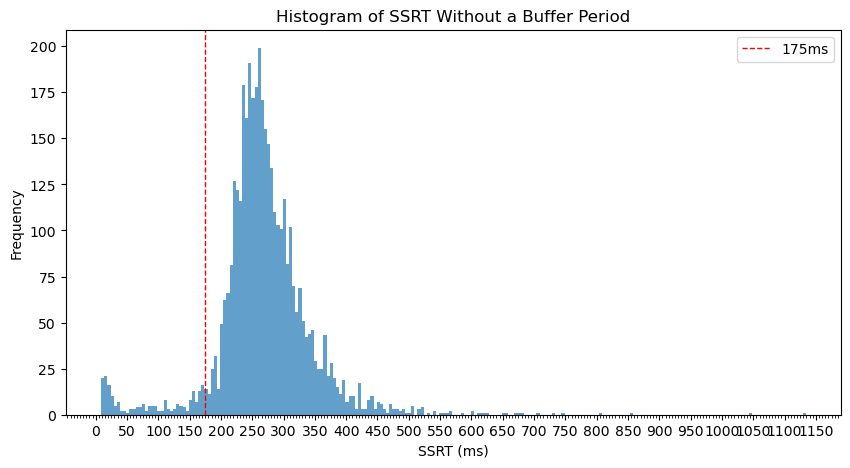

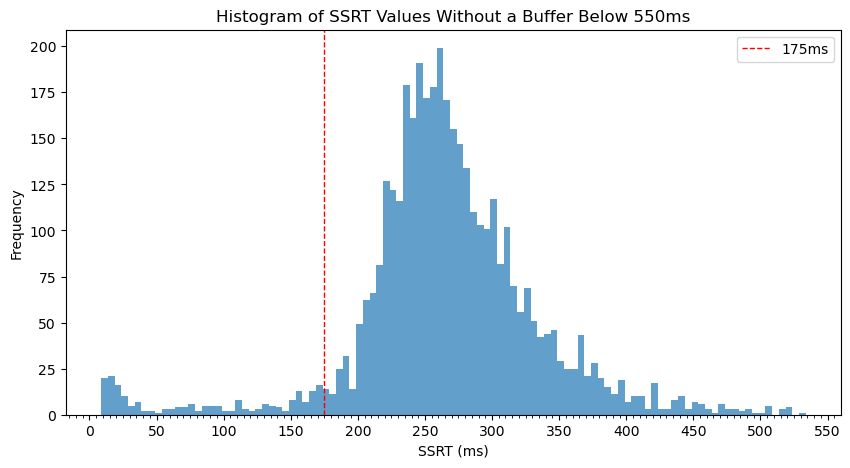

In [14]:
plot_moments_of_inhibition(data_files, data)

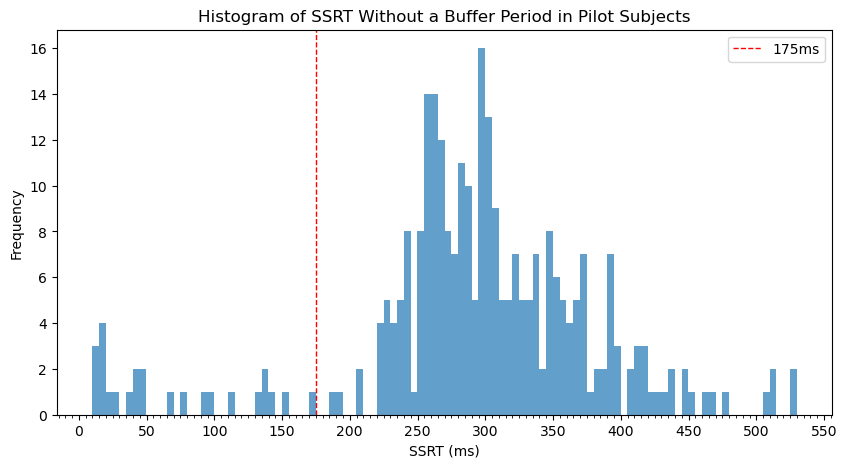

In [15]:
plot_moments_of_inhibition(pilot_files, pilot_data, exp_stage="pilot")

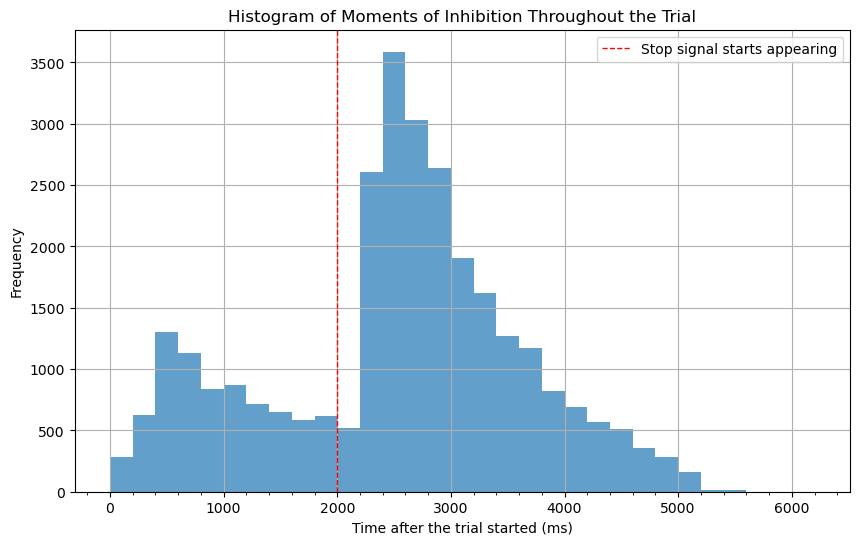

In [16]:
#Plot a histogram of all moments of inhibition, even before the stop onset. This is only for the final sample, not pilot
df = get_df_all_data(data_files, data)
all_moments = []
bin_edges = np.arange(0, 6200 + 200, 200)  # Create bins of size 200 ms

# Flatten the moments of inhibition list
for index, row in df.iterrows():
    all_moments.extend(row['moments_of_inhibition'])  # Assuming each entry is a list of timestamps

moments_df = pd.DataFrame(all_moments, columns=['moments_of_inhibition'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(moments_df['moments_of_inhibition']*1000, bins=bin_edges, alpha=0.7)
plt.title('Histogram of Moments of Inhibition Throughout the Trial')
plt.xlabel('Time after the trial started (ms)')
plt.ylabel('Frequency')
plt.axvline(x=2000, color='red', linestyle='dashed', linewidth=1, label='Stop signal starts appearing')
plt.gca().xaxis.set_major_locator(MultipleLocator(1000))  # Major ticks every 100 ms
plt.gca().xaxis.set_minor_locator(MultipleLocator(200))  # Minor ticks every 20 ms
plt.legend()
plt.grid()
plt.savefig('figures/moments_of_inhibition_throughout_trial_histogram.png')
plt.show()

In [17]:
filtered_df = df[(df['ssrt'] >= 0.0) & (df['ssrt'] <= 0.07)]
ssds_in_range = filtered_df['stop_onset']
(ssds_in_range)


9       3.121594
67      3.600421
80      2.183571
235     4.333364
295     3.687054
332     3.668747
353     2.407776
367     3.450267
410     2.278371
434     2.191287
442     3.425632
458     2.475128
514     2.132607
559     3.929534
568     4.111004
578     2.595548
811     3.302641
839     2.441104
1011    2.429590
1012    4.051004
1120    2.355913
1124    2.209928
1139    2.855025
1207    3.886327
1249    4.710193
1293    3.126258
1295    2.827511
1296    3.632439
1423    3.163170
1432    4.403778
1454    2.989323
1477    2.032167
1570    2.468519
1673    3.423311
1768    3.572841
1776    2.771683
1803    2.628647
1827    2.741127
1832    2.567453
1942    4.286474
2002    3.465887
2013    2.375847
2024    2.825340
2029    3.698483
2032    3.361392
2034    3.742211
2064    3.072614
2069    3.059569
2147    2.403807
2247    2.388652
2278    4.014832
2291    2.912506
2321    3.950085
2337    4.403621
2381    2.488014
2382    3.043263
2420    4.562475
2447    4.749533
2489    3.5401

# Comparing ai stop with non ai stop

In [18]:
data.keys()

dict_keys(['s042', 's029', 's016', 's011', 's018', 's027', 's020', 's043', 's021', 's019', 's026', 's010', 's028', 's017', 's035', 's032', 's004', 's005', 's033', 's034', 's012', 's015', 's023', 's024', 's041', 's025', 's022', 's014', 's013', 's040', 's031', 's036', 's009', 's007', 's038', 's006', 's039', 's037', 's008', 's030'])

In [19]:
data['s042'].keys()

dict_keys(['ai', 'control'])

In [20]:
data['s042']['ai'].keys()

dict_keys(['data', 'trial_results', 'ssrt_list'])

In [21]:
data['s042']['ai']['trial_results'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [22]:
data['s042']['ai']['trial_results'][0].keys()

dict_keys(['stop_onset', 'closest_time', 'index_of_closest', 'raw_pressure', 'distances_raw', 'pressures_raw', 'time_stamps_raw', 'condition', 'stop_pressure', 'stop_moment', 'moment_of_inhibition', 'index_of_inhibition', 'moments_of_inhibition', 'ssrt'])

In [23]:
stop_comparison_data = {}
for subject in data.keys():
    stop_comparison_data[subject] = {}
    for condition in data[subject].keys():
        
        stop_comparison_data[subject][condition] = {}
        
        moments_of_inhibition = []
        ssrts = []
        stop_moments = []
        
        for trial in data[subject][condition]['trial_results'].keys():
            
            if data[subject][condition]['trial_results'][trial]['condition'] == 'stop':
                moments_of_inhibition.append(data[subject][condition]['trial_results'][trial]['moment_of_inhibition'])
                ssrts.append(data[subject][condition]['trial_results'][trial]['ssrt'])
                stop_moments.append(data[subject][condition]['trial_results'][trial]['stop_moment'])

        
            
        stop_comparison_data[subject][condition]['moments_of_inhibition'] = [x if x is not None else np.nan for x in moments_of_inhibition]
        stop_comparison_data[subject][condition]['ssrts'] = [x if x is not None else np.nan for x in ssrts]
        stop_comparison_data[subject][condition]['stop_moments'] = [x if x is not None else np.nan for x in stop_moments]

In [24]:
np.nanmean(stop_comparison_data['s042']['ai']['moments_of_inhibition'])

2.8999447245150805

In [25]:
np.nanmean(stop_comparison_data['s042']['control']['moments_of_inhibition'])

3.12865997120738

In [26]:
len(stop_comparison_data['s042']['ai']['moments_of_inhibition'])

20

In [27]:
np.nanmean(stop_comparison_data['s043']['ai']['moments_of_inhibition'])

3.03675383515656

In [28]:
np.nanmean(stop_comparison_data['s043']['control']['moments_of_inhibition'])

3.2218363758176567

In [29]:
np.nanmean(stop_comparison_data['s041']['ai']['moments_of_inhibition'])

3.052603418380022

In [30]:
np.nanmean(stop_comparison_data['s041']['control']['moments_of_inhibition'])

3.1724345625936987